In [1]:
import os
import sys
sys.path.append('../')
import random
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.decomposition import PCA

import torch
from torch import nn
import torch.nn.functional  as F
from torch.utils.data import DataLoader, Dataset

In [2]:
df = pd.read_csv("../input/features.csv")

In [3]:
df.head(1)

,ip,user_agent,session,num_requests,img_to_req(%),4xx(%),Head(%),std_path_length,consq_rep_path(%),ave_response_len,sum_response_len,ave_response_time,sum_response_time,session_duration,ave_time_per_page,robot_txt,is_bot
0,1.81.122.235,Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like M...,0,7,0.0,0.0,0.0,0.0,85.714286,108702.714286,760919,41.714286,292.0,6.9,1.15,0,0


In [4]:
# simple modification!!
df.loc[(df["robot_txt"] == 1) & (df["is_bot"] == 0), "is_bot"] = 1
df.loc[df["user_agent"] == "sentry/21.4.1 (https://sentry.io)","is_bot"] = 1

In [5]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [6]:
# splitting data to normal and anomaly dataset
normal = df[df["is_bot"] == 0]
normal_index = normal.index
normal = normal.sample(frac=1).reset_index(drop=True)
print(f"{normal.shape=}")

anomaly = df[df["is_bot"] == 1]
bot_index = anomaly.index
anomaly = anomaly.sample(frac=1).reset_index(drop=True)
print(f"{anomaly.shape=}")

normal.shape=(28374, 17)
anomaly.shape=(2309, 17)


In [7]:
def prepare_datasets(normal, anomaly):
    
    """return the train, val and test set"""
    
    cols_to_model = df.drop(["ip", "user_agent","session"], axis=1).columns # "robot_txt", "is_bot"
    cols_to_scale = df.drop(["ip", "user_agent","session", "robot_txt", "is_bot"], axis=1).columns

    
    n1 = int(0.7*len(normal)) # 80% of normal data goes for training and 20% goes for test set
    xtr = normal.loc[:n1, cols_to_model]
    
    xtest = anomaly[cols_to_model].append(normal.loc[n1:, cols_to_model], ignore_index = True) # creating test set
    
#     xtest = xtest.sample(frac=1).reset_index(drop=True) # shuffling the test set
    
    
    xtrain, xvalid = train_test_split(xtr, test_size=0.2, random_state=123456) 
    
    scaler = StandardScaler()
    xtrain = scaler.fit_transform(xtrain)
    xvalid = scaler.transform(xvalid)
    xtest = scaler.transform(xtest)
    
    xtrain = torch.tensor(xtrain).float()
    xvalid = torch.tensor(xvalid).float()
    xtest = torch.tensor(xtest).float()
    
    print(f"{xtrain.size()=}")
    print(f"{xvalid.size()=}")
    print(f"{xtest.size()=}")
    
    return xtrain, xvalid, xtest   

In [8]:
xtrain, xvalid, xtest = prepare_datasets(normal, anomaly)

xtrain.size()=torch.Size([15889, 14])
xvalid.size()=torch.Size([3973, 14])
xtest.size()=torch.Size([10822, 14])


In [9]:
# creating dataloaders 
tr = DataLoader(xtrain, batch_size=32, shuffle=True)
val = DataLoader(xvalid, batch_size=32, shuffle=True)
# te = DataLoader(xtest, batch_size=32, shuffle=True)

In [10]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(self, best_valid_loss=float('inf')):
        
        self.best_valid_loss = best_valid_loss
        
    def __call__( self, current_valid_loss, epoch, model, optimizer, criterion):
        
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
#             print(f"\nBest validation loss: {self.best_valid_loss}")
#             print(f"\nSaving best model for epoch: {epoch}\n")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_model.pth')

def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'final_model.pth')

In [11]:
# autoencoder model
class Encoder(nn.Module):
    def __init__(self, input_dim, intermediate_size, bottleneck_size, initialize=True):
        super(Encoder, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, intermediate_size)
        self.layer2 = nn.Linear(intermediate_size, intermediate_size//2)
        self.layer3 = nn.Linear(intermediate_size//2, bottleneck_size)
        
        if initialize:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        
    def __call__(self, x):
        # hidden layer 1
        x = self.layer1(x)
        hl1 = F.relu(x)
        # hidden layer 2
        x = self.layer2(hl1)
        hl2 = F.relu(x)
        # bottleneck
        x = self.layer3(hl2)
        bottleneck = F.relu(x)

        return x
        
class Decoder(nn.Module):
    def __init__(self, input_dim, intermediate_size, bottleneck_size, initialize=True):
        super(Decoder, self).__init__()
        
        self.layer4 = nn.Linear(bottleneck_size, intermediate_size//2)
        self.layer5 = nn.Linear(intermediate_size//2, intermediate_size)
        self.layer6 = nn.Linear(intermediate_size, input_dim)
        
        if initialize:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                    nn.init.constant_(m.bias, 0.1)
                    
    def __call__(self, x):
        # hidden layer 4
        x = self.layer4(x)
        hl4 = F.relu(x)
        # hidden layer 5
        x = self.layer5(hl4)
        hl5 = F.relu(x)
        # output
        out = self.layer6(hl5)

        return out
        
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(input_dim, intermediate_size, bottleneck_size, initialize=True)
        self.decoder = Decoder(input_dim, intermediate_size, bottleneck_size, initialize=True)
    
    def __call__(self, x):
        encoded = self.encoder(x)
        output = self.decoder(encoded)
        return output

In [12]:
input_dim = xtrain.shape[1]
intermediate_size = 10
bottleneck_size = 2
learning_rate = 0.0025 #0.002
max_epochs = 200

model = AutoEncoder()
print("Number of parameters -- >", sum(p.numel() for p in model.parameters()))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
save_best_model = SaveBestModel()

Number of parameters -- > 446


In [13]:
# lre = torch.linspace(-3, 0, 1000) # between 0.001 and 1(how did we choose this??)
# lrs = 10 ** lre

In [14]:
# first_batch = next(iter(tr))
# first_batch.size()

# overfittin a single batch
# model.train()
# for i in range(1000):
#     optimizer.zero_grad()
#     y_pred = model(first_batch)
#     loss = criterion(y_pred, first_batch)
#     loss.backward()
#     optimizer.step()    
#     print(loss.item())   
# 0.00995

In [15]:
def evaluate(model, dataloader, criterion):
    
    model.eval()
    running_loss_val = 0.0
    
    with torch.no_grad():
        
        for x in dataloader:
            output = model(x)
            loss = criterion(output, x) 
            running_loss_val += loss.item()
        
    running_loss_val /= len(dataloader)
        
    return running_loss_val 

In [16]:
def train_eval(model, dataloader, optimizer, criterion, max_epochs = max_epochs):
    
    # collect the loss of each epoch
    train_loss = []
    eval_loss = []
    
    for epoch in range(1, max_epochs):
        
        model.train()
        running_loss_tr = 0.0 # collect the loss of each minibatch
        
        for x in dataloader:
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, x)
            loss.backward()
            optimizer.step()
            running_loss_tr += loss.item()
        
        running_loss_tr /= (len(dataloader))
        train_loss.append(running_loss_tr)
        running_loss_val = evaluate(model, dataloader, criterion)
        eval_loss.append(running_loss_val)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{max_epochs} | train_loss: {running_loss_tr:0.4f} | Valid_loss: {running_loss_val:0.4f}")
        
        save_best_model(running_loss_val, epoch, model, optimizer, criterion)
        
    save_model(max_epochs, model, optimizer, criterion)    
    return train_loss, eval_loss

In [17]:
train_loss, eval_loss = train_eval(model, tr, optimizer, criterion)

Epoch 10/200 | train_loss: 0.2965 | Valid_loss: 0.2869
Epoch 20/200 | train_loss: 0.2292 | Valid_loss: 0.2279
Epoch 30/200 | train_loss: 0.2179 | Valid_loss: 0.2304
Epoch 40/200 | train_loss: 0.2089 | Valid_loss: 0.1926
Epoch 50/200 | train_loss: 0.1904 | Valid_loss: 0.1903
Epoch 60/200 | train_loss: 0.1893 | Valid_loss: 0.1818
Epoch 70/200 | train_loss: 0.1875 | Valid_loss: 0.2136
Epoch 80/200 | train_loss: 0.1824 | Valid_loss: 0.2018
Epoch 90/200 | train_loss: 0.1833 | Valid_loss: 0.1746
Epoch 100/200 | train_loss: 0.1784 | Valid_loss: 0.1768
Epoch 110/200 | train_loss: 0.1802 | Valid_loss: 0.1797
Epoch 120/200 | train_loss: 0.1800 | Valid_loss: 0.1761
Epoch 130/200 | train_loss: 0.1862 | Valid_loss: 0.1739
Epoch 140/200 | train_loss: 0.1784 | Valid_loss: 0.1880
Epoch 150/200 | train_loss: 0.1779 | Valid_loss: 0.1756
Epoch 160/200 | train_loss: 0.1782 | Valid_loss: 0.1704
Epoch 170/200 | train_loss: 0.1770 | Valid_loss: 0.1749
Epoch 180/200 | train_loss: 0.1748 | Valid_loss: 0.1758
E

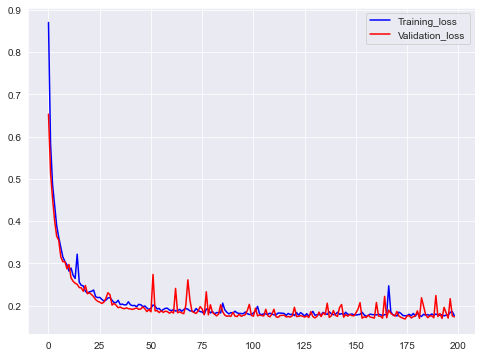

In [18]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss)), train_loss, color = "b", label = "Training_loss")
plt.plot(range(len(eval_loss)), eval_loss, color = "r", label = "Validation_loss")
plt.legend()
plt.show()

In [19]:
best_model_cp = torch.load('best_model.pth')
best_model_epoch = best_model_cp['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")
# load the last model checkpoint
last_model_cp = torch.load('final_model.pth')
last_model_epoch = last_model_cp['epoch']
print(f"Last model was saved at {last_model_epoch} epochs\n")

Best model was saved at 175 epochs

Last model was saved at 200 epochs



In [20]:
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval() 
with torch.no_grad():
    predicted = model(xtrain[10])

    for original, constructed in zip(xtrain[10], predicted):
        print(original, "-->", constructed)

tensor(-0.2642) --> tensor(-0.3066)
tensor(0.5435) --> tensor(0.5235)
tensor(-0.1171) --> tensor(-0.1212)
tensor(-0.0103) --> tensor(-0.0036)
tensor(-0.6913) --> tensor(-0.6858)
tensor(-0.2941) --> tensor(-0.2841)
tensor(0.2545) --> tensor(0.0097)
tensor(-0.0785) --> tensor(-0.1186)
tensor(-0.1635) --> tensor(-0.1540)
tensor(-0.0928) --> tensor(-0.1087)
tensor(-0.2617) --> tensor(-0.2532)
tensor(-0.3062) --> tensor(-0.2979)
tensor(0.) --> tensor(0.0005)
tensor(0.) --> tensor(-0.0002)


In [21]:
# checkpoint = torch.load('best_model.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
predicted = []
model.eval()
with torch.no_grad():
    predicted.append(model(xtest))

In [22]:
reconstructed = predicted[0]

mse =  torch.mean(torch.pow(reconstructed - xtest, 2), axis=1)

In [23]:
anomaly_test = mse[:2310]
normal_test = mse[2310:]

In [24]:
df_describe = pd.DataFrame(anomaly_test)
df_describe.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.98,0.99]).T

,count,mean,std,min,25%,50%,75%,90%,95%,98%,99%,max
0,2310.0,1106.595581,52889.980469,0.076914,0.31381,0.646214,1.350201,3.640063,7.674213,36.500209,85.752309,2542051.25


In [25]:
df_describe = pd.DataFrame(normal_test)
df_describe.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.990,.999]).T

,count,mean,std,min,25%,50%,75%,90%,95%,99%,99.9%,max
0,8512.0,0.258378,12.342793,0.000601,0.009715,0.01888,0.059026,0.152083,0.265849,1.181484,17.459669,1130.165894


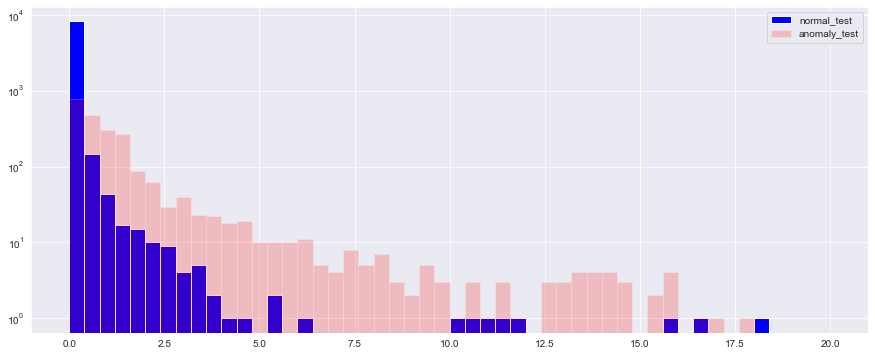

In [26]:
plt.figure(figsize=(15,6))
plt.hist(normal_test.numpy(), bins=50, range=(0, 20), color="b", label="normal_test")
plt.hist(anomaly_test.numpy(), bins=50, range=(0, 20), color="r", label="anomaly_test", alpha = 0.2)
plt.legend()
plt.yscale("log");


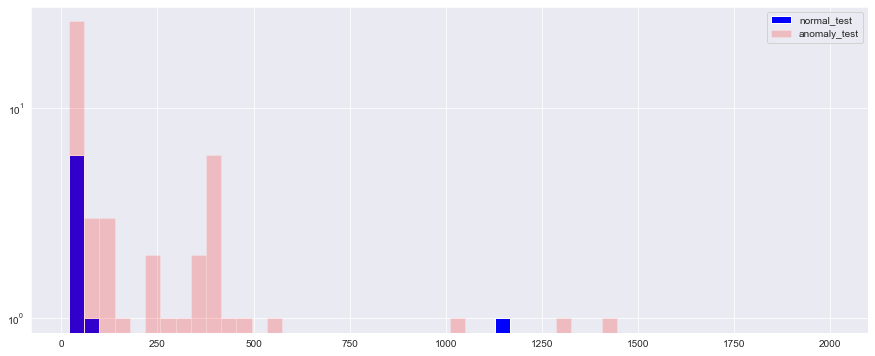

In [27]:
plt.figure(figsize=(15,6))
plt.hist(normal_test.numpy(), bins=50, range=(20, 2000), color="b", label="normal_test")
plt.hist(anomaly_test.numpy(), bins=50, range=(20, 2000), color="r", label="anomaly_test", alpha = 0.2)
plt.legend()
plt.yscale("log");

In [28]:
def compute_bottleneck(x, model):
    x = model.encoder(x)
    return x

In [29]:
representation = compute_bottleneck(xtest, model)

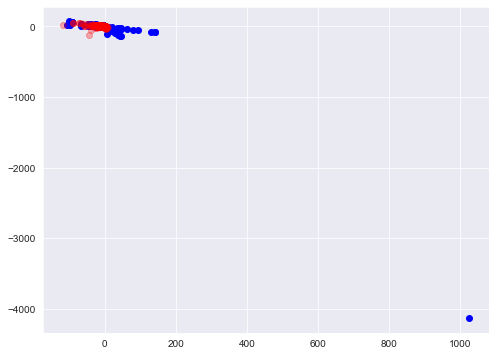

In [30]:
plt.figure(figsize=(8,6))
plt.title("Bot")
plt.scatter(representation[0:2310,0].detach().numpy(), representation[0:2310,1].detach().numpy(), color = "b");
plt.scatter(representation[2310:,0].detach().numpy(), representation[2310:,1].detach().numpy(), color = "r", alpha = 0.3);